# Importing libraries

In [91]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import ImageFolder

from torchmetrics import Accuracy
from torchinfo import summary

import numpy as np
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Defining paths

In [80]:
DATA_DIR = 'D:/DeepLearning/PyTorch/DiseaseDetection/data'

# training data directory
train_dir = DATA_DIR+'/train'

# testing data directory
test_dir = DATA_DIR+'/test'

# Walking through directories

In [81]:
import os

for dirpath, dirnames, filenames in os.walk(DATA_DIR):
    print(f'no of directory : {len(dirnames)}, no of files : {len(filenames)} and path {dirpath}')

no of directory : 3, no of files : 1 and path D:/DeepLearning/PyTorch/DiseaseDetection/data
no of directory : 3, no of files : 0 and path D:/DeepLearning/PyTorch/DiseaseDetection/data\test
no of directory : 0, no of files : 100 and path D:/DeepLearning/PyTorch/DiseaseDetection/data\test\Potato___Early_blight
no of directory : 0, no of files : 16 and path D:/DeepLearning/PyTorch/DiseaseDetection/data\test\Potato___healthy
no of directory : 0, no of files : 100 and path D:/DeepLearning/PyTorch/DiseaseDetection/data\test\Potato___Late_blight
no of directory : 3, no of files : 0 and path D:/DeepLearning/PyTorch/DiseaseDetection/data\train
no of directory : 0, no of files : 900 and path D:/DeepLearning/PyTorch/DiseaseDetection/data\train\Potato___Early_blight
no of directory : 0, no of files : 136 and path D:/DeepLearning/PyTorch/DiseaseDetection/data\train\Potato___healthy
no of directory : 0, no of files : 900 and path D:/DeepLearning/PyTorch/DiseaseDetection/data\train\Potato___Late_blig

# Transforming training and testing data

In [82]:
train_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

# Putting data in `ImageFolder`

In [83]:
train_data = ImageFolder(root = train_dir, 
                         transform = train_transforms)

test_data = ImageFolder(root = test_dir, 
                        transform = test_transforms)

In [84]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1936
     Root location: D:/DeepLearning/PyTorch/DiseaseDetection/data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 216
     Root location: D:/DeepLearning/PyTorch/DiseaseDetection/data/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [10]:
train_data.classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
train_data.class_to_idx

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

# `Data loader`

In [12]:
train_dataloader = DataLoader(dataset = train_data, 

                              # batch size
                              batch_size = 64, 
                                             # cpu to be utilized
                              shuffle = True, num_workers = os.cpu_count())

test_dataloader = DataLoader(dataset = test_data, 
                              batch_size = 64, 
                              shuffle = True, num_workers = os.cpu_count())

# Define the model

In [13]:
class ImageClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # Putting layers in Sequential module
        self.conv_layer = nn.Sequential(

            # as we gave 3 color channels we pass in_channels = 3, out_channels = 8 (neurons) using filter of size 3*3
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3),

            # Using ReLU activation 
            nn.ReLU(),

            # as we gave 3 color channels we pass in_channels = 8, out_channels = 16 (neurons) using filter of size 3*3
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3),
            nn.ReLU()
        )

        self.linear_layer = nn.Sequential(

            # flattening the layer 
            nn.Flatten(),

            # Used lazy linear - where in_features are inferred
            nn.LazyLinear(out_features = 3)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.linear_layer(x)
        return x

# MLflow tracking

In [15]:
import mlflow

# Where we want to set UI
mlflow.set_tracking_uri('http://localhost:5000')

# defining experiment name
mlflow.set_experiment('disease-detector-v1')

2024/07/03 10:51:45 INFO mlflow.tracking.fluent: Experiment with name 'disease-detector-v1' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/428911386079350019', creation_time=1719984105467, experiment_id='428911386079350019', last_update_time=1719984105467, lifecycle_stage='active', name='disease-detector-v1', tags={}>

# Define train loop

In [16]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
def train(dataloader, model, loss_fn, metrics_fn, optimizer, epoch):
    
    """Train the model on a single pass of the dataloader.

    Args:
        dataloader: an instance of `torch.utils.data.DataLoader`, containing the training data.
        model: an instance of `torch.nn.Module`, the model to be trained.
        loss_fn: a callable, the loss function.
        metrics_fn: a callable, the metrics function.
        optimizer: an instance of `torch.optim.Optimizer`, the optimizer used for training.
        epoch: an integer, the current epoch number.
    """

    # putting model to train mode
    model.train()

    # iterating through dataloader
    for batch, (X, y) in enumerate(dataloader):

        # putting X and y to whichever device available
        X, y = X.to(device), y.to(device)

        # prediction on X
        y_pred = model(X)

        # calculating loss using prediction and actual y
        loss = loss_fn(y_pred, y)

        # checking performance
        accuracy = metrics_fn(y_pred, y)

        # backpropagation
        loss.backward()

        # updating the weights and bias
        optimizer.step()

        # forgetting the previous weights and bias
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current_batch = loss.item(), batch
            step = batch // 100 * (epoch + 1)
            mlflow.log_metric("loss", f"{loss:2f}", step = step)
            mlflow.log_metric("accuracy", f"{accuracy:2f}", step = step)
            print(f"loss: {loss:2f} accuracy: {accuracy:2f} [{current_batch} / {len(dataloader)}]")

# Define Evaluating loop

In [27]:
def evaluate(dataloader, model, loss_fn, metrics_fn, epoch):
    """Evaluate the model on a single pass of the dataloader.

    Args:
        dataloader: an instance of `torch.utils.data.DataLoader`, containing the eval data.
        model: an instance of `torch.nn.Module`, the model to be trained.
        loss_fn: a callable, the loss function.
        metrics_fn: a callable, the metrics function.
        epoch: an integer, the current epoch number.
    """

    num_batches = len(dataloader)
    model.eval()
    eval_loss, eval_accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            eval_loss += loss_fn(y_pred, y).item()
            eval_accuracy += metrics_fn(y_pred, y)

    eval_loss = eval_loss / num_batches
    eval_accuracy = eval_accuracy / num_batches
    mlflow.log_metric("eval_loss", f"{eval_loss:2f}", step = epoch)
    mlflow.log_metric("eval_accuracy", f"{eval_accuracy:2f}", step = epoch)

    print(f"Eval metrics: \nAccuracy: {eval_accuracy:.2f}, Avg loss: {eval_loss:2f} \n")
    

# Starting loop

In [53]:
epochs = 10
model_v1 = ImageClassifier()

loss_fn = nn.CrossEntropyLoss()
metrics_fn = Accuracy(task = 'multiclass', num_classes = len(train_data.classes))
optimizer = torch.optim.SGD(model_v1.parameters(), lr = 0.003)

D:\DeepLearning\PyTorch\.pytorch_env\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [55]:
with mlflow.start_run() as run:

    # defining parametrs which you want to monitor
    params = {
        "epochs" : epochs,
        "learning_rate" : 0.003,
        "batch size" : 64,
        "loss function" : loss_fn.__class__.__name__,
        "metric function" : metrics_fn.__class__.__name__,
        "optimizer" : "SGD"
    }

    # log training parameters
    mlflow.log_params(params)

    # log model summary
    with open("model_summary.txt", "w", encoding = "utf-8") as f:
        f.write(str(summary(model_v1)))
    mlflow.log_artifact("model_summary.txt")

    for e in range(epochs):
        print(f"Epoch {e+1}\n-------------------------------")
        
        train(train_dataloader, model_v1, loss_fn, metrics_fn, optimizer, epoch = e)
        evaluate(test_dataloader, model_v1, loss_fn, metrics_fn, epoch = 0)

    mlflow.pytorch.log_model(model_v1, "model_v1")

Epoch 1
-------------------------------
loss: 1.102723 accuracy: 0.531250 [0 / 31]
Eval metrics: 
Accuracy: 0.47, Avg loss: 0.898024 

Epoch 2
-------------------------------
loss: 0.880787 accuracy: 0.437500 [0 / 31]
Eval metrics: 
Accuracy: 0.64, Avg loss: 0.788361 

Epoch 3
-------------------------------
loss: 0.819947 accuracy: 0.609375 [0 / 31]
Eval metrics: 
Accuracy: 0.50, Avg loss: 0.854247 

Epoch 4
-------------------------------
loss: 0.778820 accuracy: 0.515625 [0 / 31]
Eval metrics: 
Accuracy: 0.75, Avg loss: 0.687416 

Epoch 5
-------------------------------
loss: 0.589838 accuracy: 0.859375 [0 / 31]
Eval metrics: 
Accuracy: 0.84, Avg loss: 0.625197 

Epoch 6
-------------------------------
loss: 0.554235 accuracy: 0.859375 [0 / 31]
Eval metrics: 
Accuracy: 0.72, Avg loss: 0.626908 

Epoch 7
-------------------------------
loss: 0.493135 accuracy: 0.796875 [0 / 31]
Eval metrics: 
Accuracy: 0.63, Avg loss: 0.764403 

Epoch 8
-------------------------------
loss: 0.669943 

2024/07/03 12:24:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/07/03 12:24:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [56]:
# Downloading the trained model
logged_model = f"runs:/{run.info.run_id}/model_v1"

# loading the downloaded model for prediction
logged_model = mlflow.pyfunc.load_model(logged_model)

In [57]:
# prediction
outputs = logged_model.predict(train_data[0][0][None, :].numpy())

In [59]:
class_names = train_data.classes

In [60]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [93]:
from tqdm import tqdm

y_preds = []
# logged_model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc = 'making predictions'):
    y_logits = logged_model.predict(X.numpy())
    y_pred = torch.softmax(torch.tensor(y_logits).squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:5]

making predictions: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.57s/it]


tensor([1, 1, 2, 1, 2])

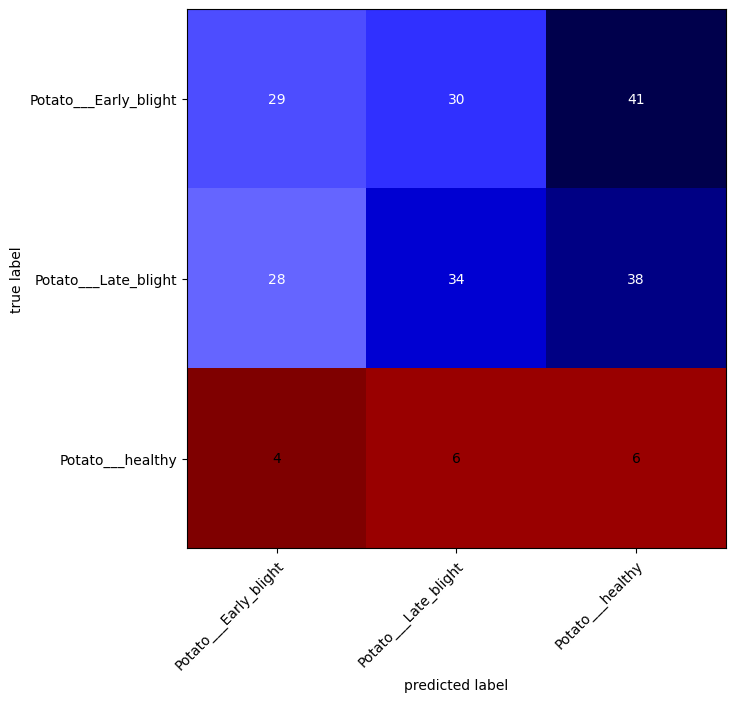

In [94]:
confmat = ConfusionMatrix(task="multiclass", num_classes = 3)
cm = confmat(y_pred_tensor, torch.tensor(test_data.targets))

fig, ax = plot_confusion_matrix(conf_mat = cm.numpy(),
                                class_names = class_names,
                                figsize=(10, 7), cmap = 'seismic_r')

In [95]:
from torchmetrics.classification import MulticlassPrecision
mcp = MulticlassPrecision(num_classes=3)
mcp(y_pred_tensor, torch.tensor(test_data.targets))

tensor(0.3439)

In [65]:
epochs = 10
# model_v1 = ImageClassifier()

loss_fn = nn.CrossEntropyLoss()
metrics_fn = Accuracy(task = 'multiclass', num_classes = len(train_data.classes))
optimizer = torch.optim.Adam(model_v1.parameters(), lr = 0.003)

In [66]:
with mlflow.start_run() as run:

    params = {
        "epochs" : epochs,
        "learning_rate" : 0.003,
        "batch size" : 32,
        "loss function" : loss_fn.__class__.__name__,
        "metric function" : metrics_fn.__class__.__name__,
        "optimizer" : "Adam"
    }

    # log training parameters
    mlflow.log_params(params)

    # log model summary
    with open("model_summary.txt", "w", encoding = "utf-8") as f:
        f.write(str(summary(model_v1)))
    mlflow.log_artifact("model_summary.txt")

    for e in range(epochs):
        print(f"Epoch {e+1}\n-------------------------------")
        
        train(train_dataloader, model_v1, loss_fn, metrics_fn, optimizer, epoch = e)
        evaluate(test_dataloader, model_v1, loss_fn, metrics_fn, epoch = 0)

    mlflow.pytorch.log_model(model_v1, "model_v1")

Epoch 1
-------------------------------
loss: 0.503224 accuracy: 0.796875 [0 / 31]
Eval metrics: 
Accuracy: 0.87, Avg loss: 0.385056 

Epoch 2
-------------------------------
loss: 0.450786 accuracy: 0.781250 [0 / 31]
Eval metrics: 
Accuracy: 0.85, Avg loss: 0.354688 

Epoch 3
-------------------------------
loss: 0.443664 accuracy: 0.828125 [0 / 31]
Eval metrics: 
Accuracy: 0.87, Avg loss: 0.333412 

Epoch 4
-------------------------------
loss: 0.253368 accuracy: 0.921875 [0 / 31]
Eval metrics: 
Accuracy: 0.92, Avg loss: 0.236657 

Epoch 5
-------------------------------
loss: 0.198682 accuracy: 0.906250 [0 / 31]
Eval metrics: 
Accuracy: 0.92, Avg loss: 0.242015 

Epoch 6
-------------------------------
loss: 0.112228 accuracy: 0.984375 [0 / 31]
Eval metrics: 
Accuracy: 0.89, Avg loss: 0.288862 

Epoch 7
-------------------------------
loss: 0.233050 accuracy: 0.921875 [0 / 31]
Eval metrics: 
Accuracy: 0.92, Avg loss: 0.217789 

Epoch 8
-------------------------------
loss: 0.102207 

2024/07/03 12:43:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/07/03 12:44:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [67]:
from tqdm import tqdm

y_preds = []
model_v1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc = 'making predictions'):
    y_logits = model_v1(X)
    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:5]

making predictions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.19s/it]


tensor([1, 1, 0, 0, 1])

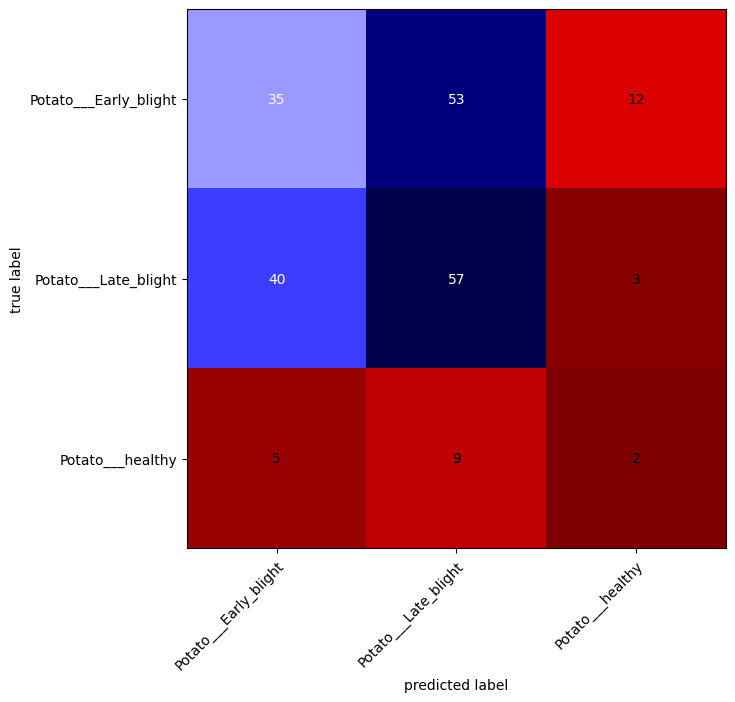

In [68]:
confmat = ConfusionMatrix(task="multiclass", num_classes = 3)
cm = confmat(y_pred_tensor, torch.tensor(test_data.targets))

fig, ax = plot_confusion_matrix(conf_mat = cm.numpy(),
                                class_names = class_names,
                                figsize=(10, 7), cmap = 'seismic_r')

In [69]:
from torchmetrics.classification import MulticlassPrecision
mcp = MulticlassPrecision(num_classes=3)
mcp(y_pred_tensor, torch.tensor(test_data.targets))

tensor(0.3447)

In [72]:
import random
from pathlib import Path

# image_path = Path(train_dir).glob('*/*.JPG')
random_image_path = random.choice(train_dir)

In [73]:
random_image_path

':'

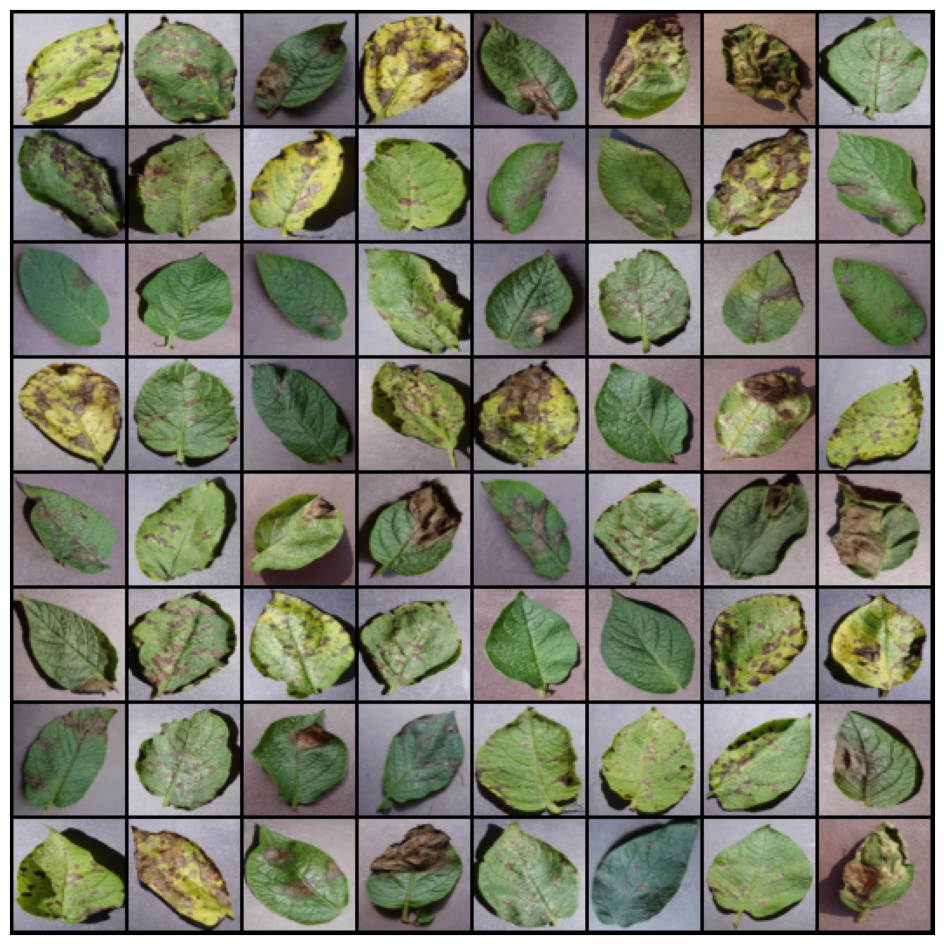

In [88]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break
        
show_batch(train_dataloader)